<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agentchat_groupchat_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Group Chat with Coder and Visualization Critic

`autogen` offers conversable agents powered by LLM, tool or human, which can be used to perform tasks collectively via automated chat. This framwork allows tool use and human participance through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

## Requirements

Autogen requires `Python>=3.8`. To run this notebook example, please install pyautogen:
```bash
pip install pyautogen
```

In [1]:
%%capture --no-stderr
# %pip install pyautogen

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/FLAML/docs/reference/autogen/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [2]:
import autogen

config_list_gpt4 = autogen.config_list_from_json(
    "../../OAI_CONFIG_LIST",
     
) 

In [3]:
user_profile = """
Saleema Amershi is a research manager at Microsoft Resesarch, Redmond. She did her PhD at the University of Washington, studying problems at the intersection of HCI and AI. Her dissertation studied how everyday people can interactively teach machine learning systems. Since joining Microsoft, Saleema has continued to study problems at this intersection including creating tools to help developers build and evaluate AI models, guidance and best practices for designing intuitive human-AI interaction, and tools to anticipate, detect, and minimize downstream consequences of AI-driven systems. Most recently, she has been studying how to enable LFM-based systems to adapt, learn, and improve based on continuous feedback.

 

Saleema is a mother of two little boys, aged 3 and 5. They keep her very busy and entertained. She enjoys spending time with her family. She does arts and crafts with her eldest son and builds forts and towers with her littler one. She loves reading them stories, having dance parties, and going on little adventures with them.

 

Saleema tries to balance her time effetively between her job and family. As such, she prefers efficiency, directness, extreme brevity, and clear organization in all aspects of her life. She is a minimalist and appreciates simplicity. She prefers simplicity and conciseness in all forms of communication including writing, speaking, visuals, and design. She prefers to use short bullet points, lists, and other visual cues to highlight important points. She prefers to use the active voice. She also appreciates humor and wit, and enjoys working with people who are able to communicate in a way that is both clear and engaging.


"""

# Personalization critic
reviewer_sys_message =f"""
You will be receiving messages from an assistant who was contracted by the individual employer with the the follow biography:

<biography>
{user_profile}
</biography>

Your job is to provide a final quality-check. YOU MUST ENSURE THAT THE ASSISTANT'S OUTPUT ADHERES TO THE RELEVANT  INTERESTS AND PREFERENCES IN THE BIOGRAPHY ABOVE. If you find that the assistants' responses are deficient with respect to this biography, you will provide specific critical feedback to help the assistant improve their output. 

TO DO THIS, YOU MUST FIRST OUTLINE ASPECTS OF THE BIO THAT ARE RELEVANT TO THE ASSISTANT'S OUTPUT AND THEN PROVIDE SPECIFIC FEEDBACK ON HOW THE ASSISTANT'S OUTPUT CAN BE IMPROVED.


Remember that you are the expert on what the employer wants BASED ON THE BIO provided. The contracted assistant has not previously worked for the  employer, and does not know them. YOU MUST THINK STEP BY STEP, AND CHECK IF THE ASSISTANT'S OUTPUT MEETS THE RELEVANT ASPECTS OF THE BIO. You may need to provide the assistant with relevant aspects of the  biographic information for them to complete the task. Once everything looks ok and there is no feedback necessary, simply reply with "all looks good, thank you, please proceed!".
"""
# print(reviewer_sys_message)


## Construct Agents

In [4]:
llm_config = {"config_list": config_list_gpt4, "seed": 42}
user_proxy = autogen.UserProxyAgent(
   name="user_proxy_assistant",
   system_message="A human admin.",
   code_execution_config={"last_n_messages": 3, "work_dir": "groupchat"},
   human_input_mode="NEVER",
)
coder = autogen.AssistantAgent(
    name="code_writer_assistant",  # the default assistant agent is capable of solving problems with code
    llm_config=llm_config,
)
visualization_critic = autogen.AssistantAgent(
    name="visualization_critic_assistant",
    system_message="""Critic. You are a helpful assistant highly skilled in evaluating the quality of a given visualization code by providing a score from 1 (bad) - 10 (good) while providing clear rationale. YOU MUST CONSIDER VISUALIZATION BEST PRACTICES for each evaluation. Specifically, you can carefully evaluate the code across the following dimensions
- bugs (bugs):  are there bugs, logic errors, syntax error or typos? Are there any reasons why the code may fail to compile? How should it be fixed? If ANY bug exists, the bug score MUST be less than 5.
- Data transformation (transformation): Is the data transformed appropriately for the visualization type? E.g., is the dataset appropriated filtered, aggregated, or grouped  if needed? If a date field is used, is the date field first converted to a date object etc?
- Goal compliance (compliance): how well the code meets the specified visualization goals?
- Visualization type (type): CONSIDERING BEST PRACTICES, is the visualization type appropriate for the data and intent? Is there a visualization type that would be more effective in conveying insights? If a different visualization type is more appropriate, the score MUST BE LESS THAN 5.
- Data encoding (encoding): Is the data encoded appropriately for the visualization type?
- aesthetics (aesthetics): Are the aesthetics of the visualization appropriate for the visualization type and the data? Are there color or other improvements that can improve the visual appearance?

YOU MUST PROVIDE A SCORE for each of the above dimensions.
{bugs: 0, transformation: 0, compliance: 0, type: 0, encoding: 0, aesthetics: 0}
Do not suggest code. 
Finally, based on the critique above, suggest a concrete list of actions that the coder should take to improve the code.
""",
    llm_config=llm_config,
)

# create a UserProxyAgent instance named "user"
personalization_critic = autogen.AssistantAgent(
    "personlization_critic_assistant",
    llm_config=llm_config,
    system_message=reviewer_sys_message,
    max_consecutive_auto_reply=20,
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, visualization_critic, personalization_critic], messages=[], max_round=20)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

## Start Chat

In [5]:
user_proxy.reset()
coder.reset()
visualization_critic.reset()
personalization_critic.reset()


groupchat = autogen.GroupChat(agents=[user_proxy, coder, visualization_critic, personalization_critic], messages=[], max_round=20)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)


user_proxy.initiate_chat(manager, message="download data from https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv and show me a plot that tells me about the amount of each weather . Save the plot as an image to disc. Print the fields in a dataset before visualizing it. Take the feedback from the critic to improve the code.")


user_proxy_assistant (to chat_manager):

download data from https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv and show me a plot that tells me about the amount of each weather . Save the plot as an image to disc. Print the fields in a dataset before visualizing it. Take the feedback from the critic to improve the code.

--------------------------------------------------------------------------------
code_writer_assistant (to chat_manager):

As an AI model, I will assist you step-by-step to accomplish your task, since due to the limitation of the interactive capabilities in this platform, you need to execute the instructions provided.

1. Download the data
Use the following Python script to download the csv data and save it locally as `seattle-weather.csv`.

Python Code:

```python
# filename: download_data.py

import pandas as pd

# Url to download the csv data
url = 'https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv'

# Use pan

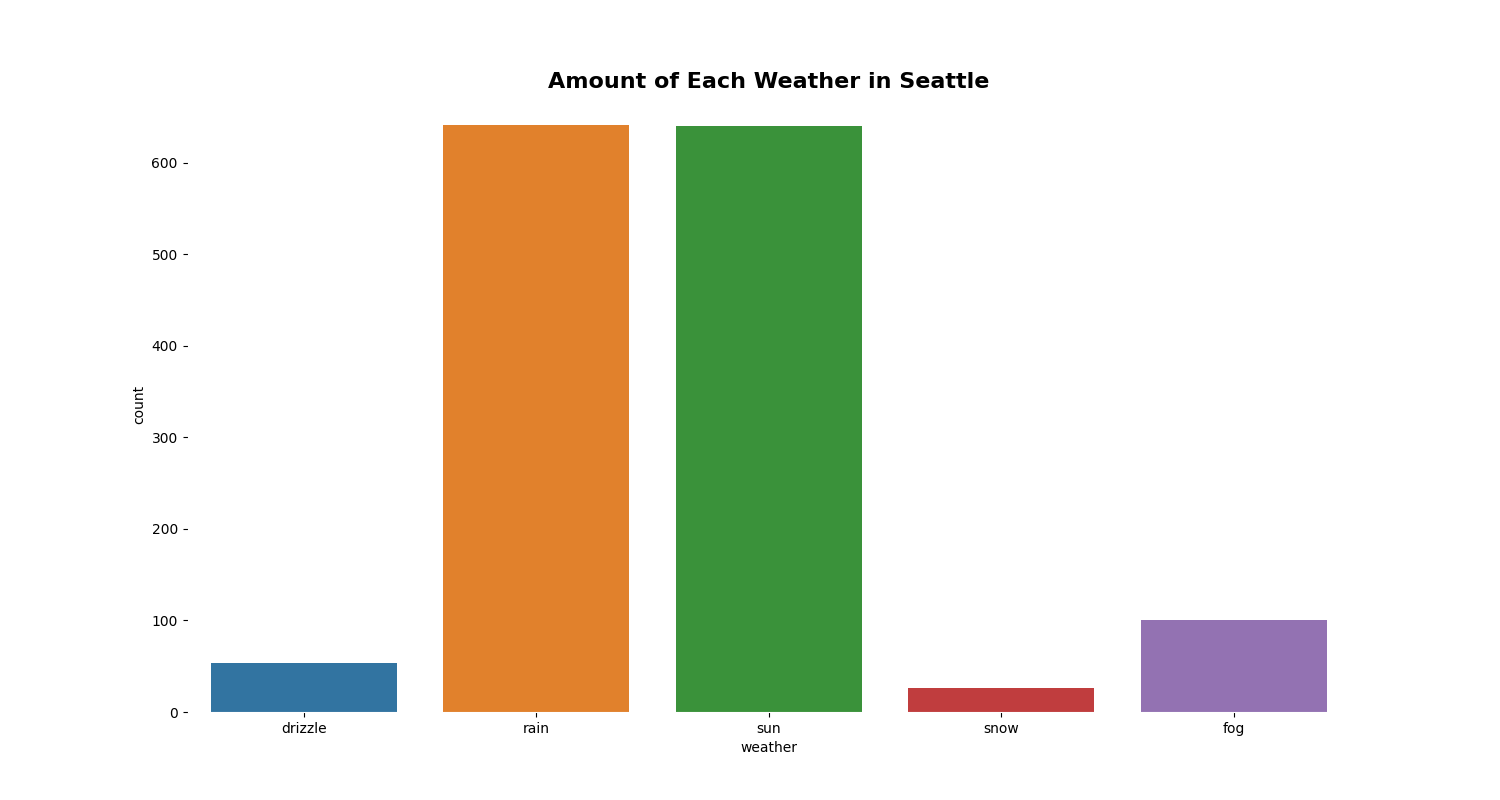

In [6]:
from IPython.display import Image
Image(filename='seattle_weather_plot.png') 